In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import re
import seaborn as sns

In [3]:
data = pd.read_csv(r'D:\ML_Projects\Quora-Question-Similarity-Pair\data\train.csv')


## Basic Data Exploration

In [4]:
print(data.shape)

(404290, 6)


In [5]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
data = data.dropna()

In [8]:
data.shape

(404287, 6)

In [9]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
data.describe()

,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [12]:
print(data.is_duplicate.value_counts())
print(data.is_duplicate.value_counts()/data.is_duplicate.value_counts().sum()*100)

0    255024
1    149263
Name: is_duplicate, dtype: int64
0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64


duplicate question containing data point are 36.92% and non duplicate containing data point are 63.08%

In [13]:
qids = np.append(data.qid1.values , data.qid2.values)
qids.shape

(808574,)

In [14]:
print("total no of unique question in data set: ", len(set(qids)))

total no of unique question in data set:  537929


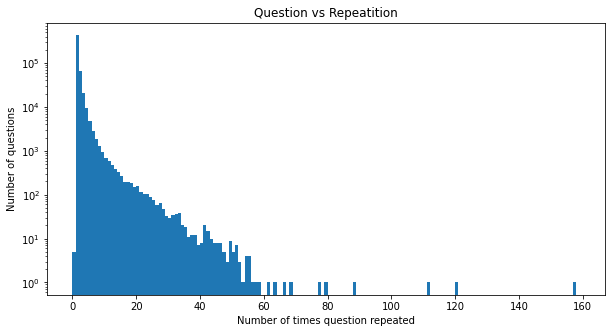

Minimun occurences of any question:  0
Maximum occurences of any question:  157


In [15]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,160))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print("Minimun occurences of any question: " , np.min(occurences))
print("Maximum occurences of any question: " , np.max(occurences))



## Data preprocessing

In [16]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [17]:
class TextPreprocessing:
    
    def __init__(self , data):
        self.data = data
        self.my_stopword = list(stopwords.words('english'))
        self.my_lemmatizer = WordNetLemmatizer()
    
    def text_preprocessing(self , data , column_name):
        
        data_copy = data.copy()
        
        data_copy[column_name] = data_copy[column_name].apply(self.lower_text)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_punctuation)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_numeric_to_string)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_urls)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_special_character_to_string_equalent)
        data_copy[column_name] = data_copy[column_name].apply(self.decontrate_words)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_stopwords)
        data_copy[column_name] = data_copy[column_name].apply(self.text_lemmatization)
        
        return data_copy
        
    
    def lower_text(self , text):
        return text.lower().strip()
    
    def remove_punctuation(self , text):
        text = text.translate(str.maketrans("", "", string.punctuation)) 
        return text
    
    def replace_numeric_to_string(self, text):
        text = text.replace(',000,000,000 ', 'b ')
        text = text.replace(',000,000 ', 'm ')
        text = text.replace(',000', 'k ')
        text = re.sub(r'([0-9]+)000000000' , r'\1b', text)
        text = re.sub(r'([0-9]+)000000' , r'\1m', text)
        text = re.sub(r'([0-9]+)000' , r'\1k', text)
        return text
    
    def remove_urls(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def replace_special_character_to_string_equalent(self , text):
        text = text.replace('%' , ' percent')
        text = text.replace('$' , ' dollar')
        text = text.replace('₹' , ' repee')
        text = text.replace('€' , ' euro')
        text = text.replace('@' , ' at')
        return text
    
    def remove_stopwords(self , text):
        words = text.split()
        new_words = [word for word in words if not word in self.my_stopword]
        text = ' '.join(new_words)
        return text
    
    def text_lemmatization(self , text):
        text = ' '.join([self.my_lemmatizer.lemmatize(word) for word in text.split()])
        return text
    
    def decontrate_words(self , text):
        contractions = { 
            "ain't": "am not",
            "aren't": "are not",
            "can't": "can not",
            "can't've": "can not have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'd've": "he would have",
            "he'll": "he will",
            "he'll've": "he will have",
            "he's": "he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how is",
            "i'd": "i would",
            "i'd've": "i would have",
            "i'll": "i will",
            "i'll've": "i will have",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it'd": "it would",
            "it'd've": "it would have",
            "it'll": "it will",
            "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
           }
        
        text_decontrate = []
        
        for word in text.split():
            if word in contractions:
                word = contractions[word]
            text_decontrate.append(word)
    
        text = ' '.join(text_decontrate)
        
        return text
    

In [18]:
tp = TextPreprocessing(data)
data_ = tp.text_preprocessing(data , 'question1')
data__ = tp.text_preprocessing(data_ , 'question2')


In [19]:
data__.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


## Features Engineering

In [19]:
from fuzzywuzzy import fuzz

In [20]:
class FeatureEngineering:
    
    def __init__(self , data):
        self.data = data
        
    
    def feature_extraction(self , data):
        
        data_copy = data.copy()
        
        data_copy['length_of_q1'] = data_copy['question1'].apply(lambda text : len(text))
        
        data_copy['length_of_q2'] = data_copy['question2'].apply(lambda text : len(text))
        
        data_copy['total_number_of_words_in_q1'] = data_copy['question1'].apply(lambda text : len(nltk.word_tokenize(text)))
        
        data_copy['total_number_of_words_in_q2'] = data_copy['question2'].apply(lambda text : len(nltk.word_tokenize(text)))
        
        data_copy['sum_of_total_words_of_q1_and_q2'] = data_copy['total_number_of_words_in_q1'] + data_copy['total_number_of_words_in_q2']
        
        data_copy['number_of_unique_words_in_q1'] = data_copy['question1'].apply(lambda text : len(set(nltk.word_tokenize(text))))
        
        data_copy['number_of_unique_words_in_q2'] = data_copy['question2'].apply(lambda text : len(set(nltk.word_tokenize(text))))
        
        data_copy['sum_of_total_uinque_words_of_q1_and_q2'] = data_copy['number_of_unique_words_in_q1'] + data_copy['number_of_unique_words_in_q2']
        
        data_copy['ratio_of_total_unique_words_and_total_words'] = data_copy['sum_of_total_uinque_words_of_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']
        
        data_copy['number_of_common_words_in_q1_and_q2'] = data_copy.apply(lambda x : len(set(x.question1.split()).intersection(set(x.question2.split()))) , axis=1)
        
        data_copy['ratio_of_common_words_of_q1q2_and_total_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']
        
        data_copy['ratio_of_common_words_of_q1q2_and_total_unique_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_uinque_words_of_q1_and_q2']
        
        data_copy['ratio_of_common_words_and_length_of_smaller_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.minimum(data_copy['length_of_q1'] , data_copy['length_of_q2'])
        
        data_copy['ratio_of_common_words_and_length_of_larger_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.maximum(data_copy['length_of_q1'] , data_copy['length_of_q2'])
        
        return data_copy
    
    def add_fuzzywuzzy_features(self , data):
        
        data_copy = data.copy()
        
        data_copy['fuzz_ratio'] = data_copy.apply(lambda x : fuzz.ratio(x.question1 , x.question2) , axis=1)
        
        data_copy['fuzz_partial_ratio'] = data_copy.apply(lambda x : fuzz.partial_ratio(x.question1 , x.question2) , axis=1)
    
        data_copy['fuzz_token_sort_ratio'] = data_copy.apply(lambda x : fuzz.token_sort_ratio(x.question1 , x.question2) , axis=1)
    
        data_copy['fuzz_token_set_ratio'] = data_copy.apply(lambda x : fuzz.token_set_ratio(x.question1 , x.question2) , axis=1)
        
        return data_copy
    

In [21]:
fe = FeatureEngineering(data__)
df = fe.feature_extraction(data__)
df = fe.add_fuzzywuzzy_features(df)

In [22]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,...,ratio_of_total_unique_words_and_total_words,number_of_common_words_in_q1_and_q2,ratio_of_common_words_of_q1q2_and_total_words,ratio_of_common_words_of_q1q2_and_total_unique_words,ratio_of_common_words_and_length_of_smaller_question,ratio_of_common_words_and_length_of_larger_question,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41,35,7,6,...,0.846154,5,0.384615,0.454545,0.142857,0.121951,92,100,92,100
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,31,67,4,9,...,0.846154,2,0.153846,0.181818,0.064516,0.029851,59,94,59,84
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44,36,6,5,...,1.000000,2,0.181818,0.181818,0.055556,0.045455,55,56,70,70
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0,21,40,3,5,...,1.000000,0,0.000000,0.000000,0.000000,0.000000,23,29,23,23
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60,29,10,5,...,1.000000,2,0.133333,0.133333,0.068966,0.033333,43,52,40,51


In [23]:
df.shape

(404287, 24)

In [24]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'length_of_q1', 'length_of_q2', 'total_number_of_words_in_q1',
       'total_number_of_words_in_q2', 'sum_of_total_words_of_q1_and_q2',
       'number_of_unique_words_in_q1', 'number_of_unique_words_in_q2',
       'sum_of_total_uinque_words_of_q1_and_q2',
       'ratio_of_total_unique_words_and_total_words',
       'number_of_common_words_in_q1_and_q2',
       'ratio_of_common_words_of_q1q2_and_total_words',
       'ratio_of_common_words_of_q1q2_and_total_unique_words',
       'ratio_of_common_words_and_length_of_smaller_question',
       'ratio_of_common_words_and_length_of_larger_question', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio'],
      dtype='object')

## Exploratery Data Analysis

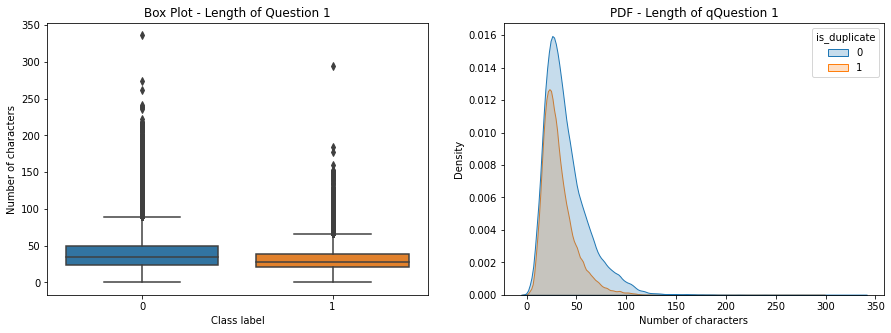

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q1' , data=df)
plt.title('Box Plot - Length of Question 1')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q1' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 1')
plt.xlabel('Number of characters')

plt.show()

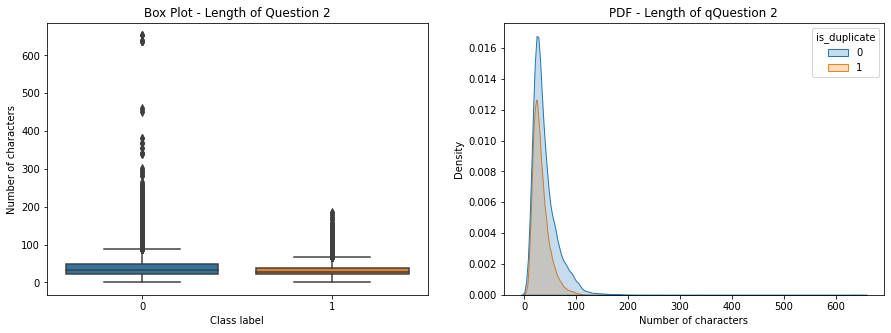

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q2' , data=df)
plt.title('Box Plot - Length of Question 2')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q2' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 2')
plt.xlabel('Number of characters')

plt.show()

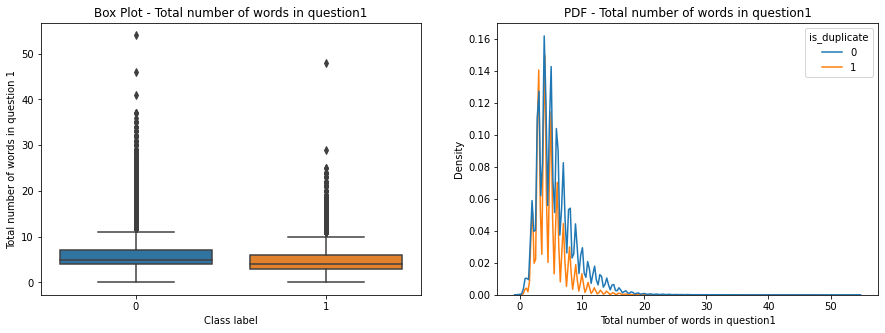

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q1' , data=df)
plt.title('Box Plot - Total number of words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question1')
plt.xlabel('Total number of words in question1')

plt.show()

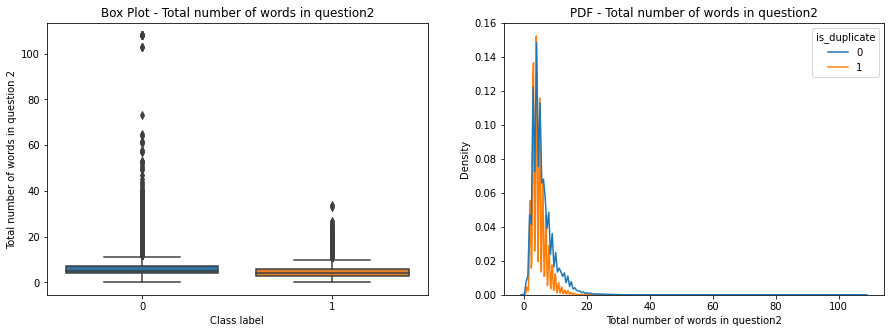

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q2' , data=df)
plt.title('Box Plot - Total number of words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question2')
plt.xlabel('Total number of words in question2')

plt.show()

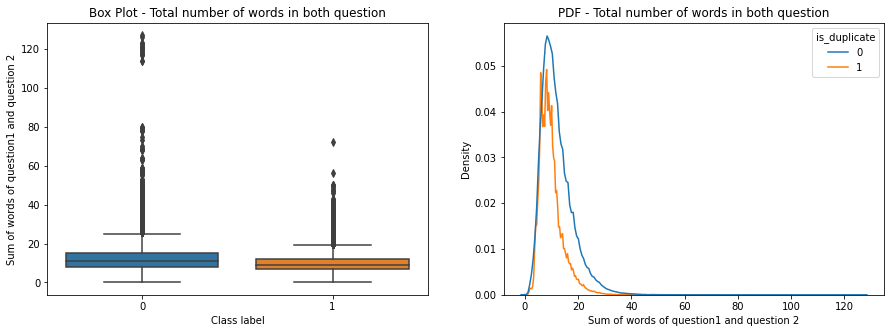

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in both question')
plt.xlabel('Sum of words of question1 and question 2')

plt.show()

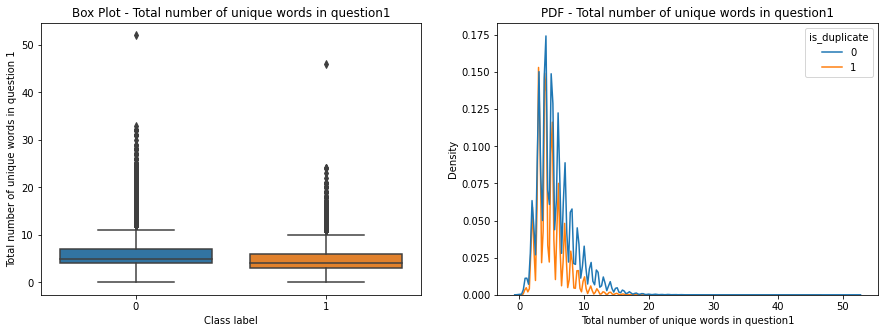

In [30]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q1' , data=df)
plt.title('Box Plot - Total number of unique words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question1')
plt.xlabel('Total number of unique words in question1')

plt.show()

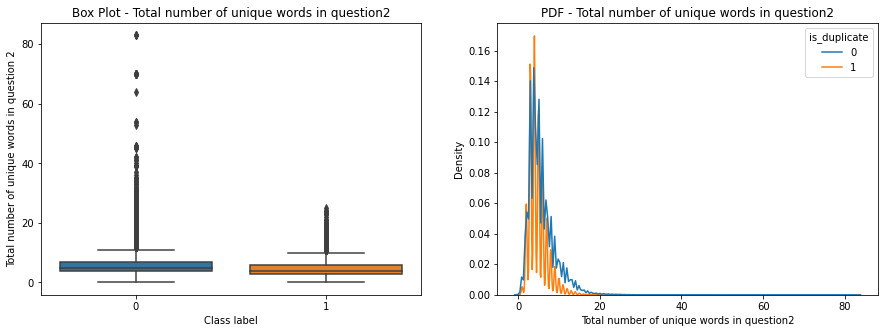

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q2' , data=df)
plt.title('Box Plot - Total number of unique words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question2')
plt.xlabel('Total number of unique words in question2')

plt.show()

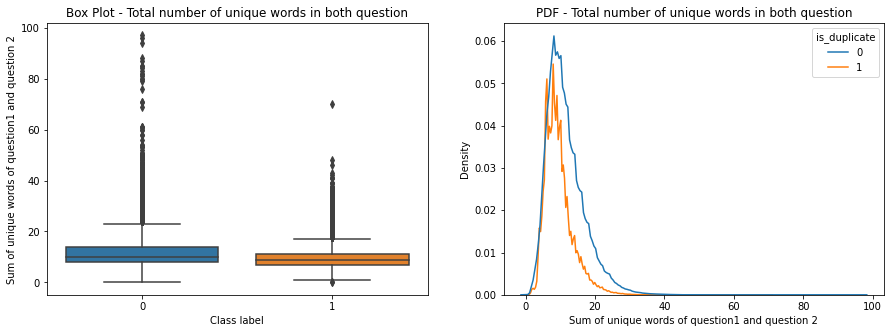

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_uinque_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of unique words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of unique words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_uinque_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in both question')
plt.xlabel('Sum of unique words of question1 and question 2')

plt.show()

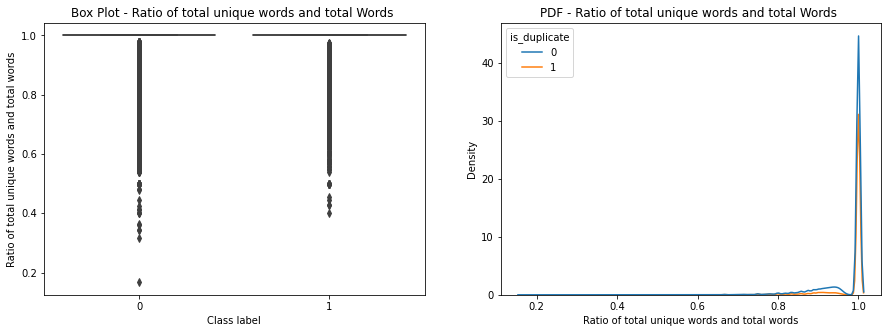

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_total_unique_words_and_total_words', data=df)
plt.title('Box Plot - Ratio of total unique words and total Words ')
plt.xlabel('Class label')
plt.ylabel('Ratio of total unique words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_total_unique_words_and_total_words', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of total unique words and total Words ')
plt.xlabel('Ratio of total unique words and total words')

plt.show()

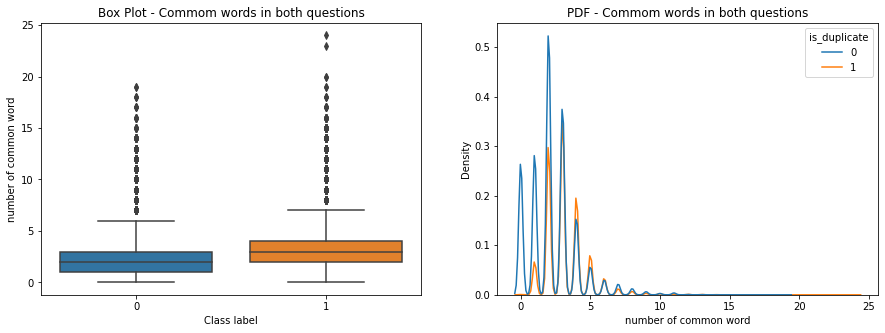

In [34]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_common_words_in_q1_and_q2', data=df)
plt.title('Box Plot - Commom words in both questions')
plt.xlabel('Class label')
plt.ylabel('number of common word')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_common_words_in_q1_and_q2', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Commom words in both questions')
plt.xlabel('number of common word')

plt.show()

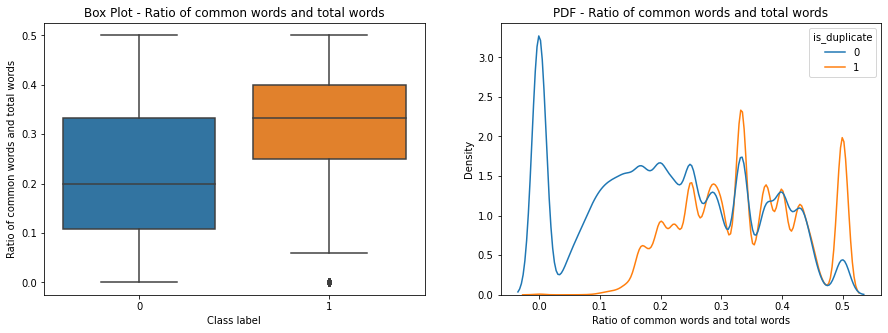

In [35]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_words' , data=df)
plt.title('Box Plot - Ratio of common words and total words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total words')
plt.xlabel('Ratio of common words and total words')

plt.show()

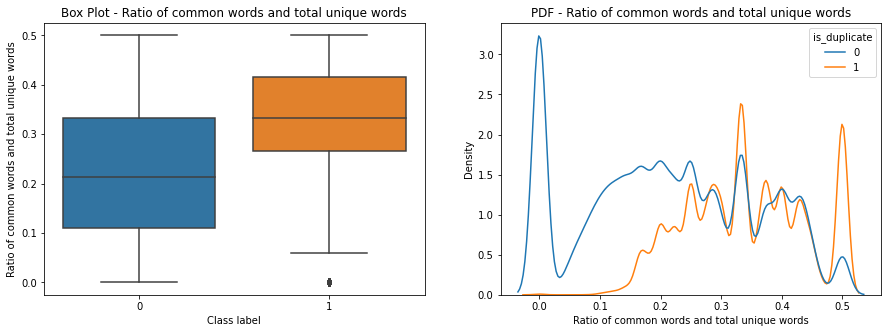

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_unique_words' , data=df)
plt.title('Box Plot - Ratio of common words and total unique words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total unique words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_unique_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total unique words')
plt.xlabel('Ratio of common words and total unique words')

plt.show()

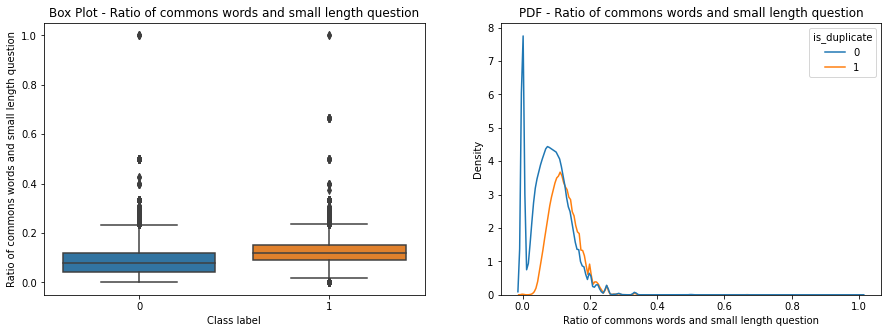

In [37]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_smaller_question' , data=df)
plt.title('Box Plot - Ratio of commons words and small length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and small length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_smaller_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and small length question')
plt.xlabel('Ratio of commons words and small length question')

plt.show()

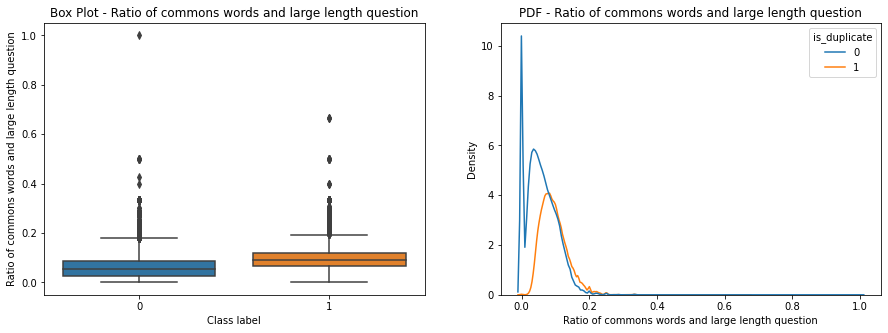

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_larger_question' , data=df)
plt.title('Box Plot - Ratio of commons words and large length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and large length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_larger_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and large length question')
plt.xlabel('Ratio of commons words and large length question')

plt.show()

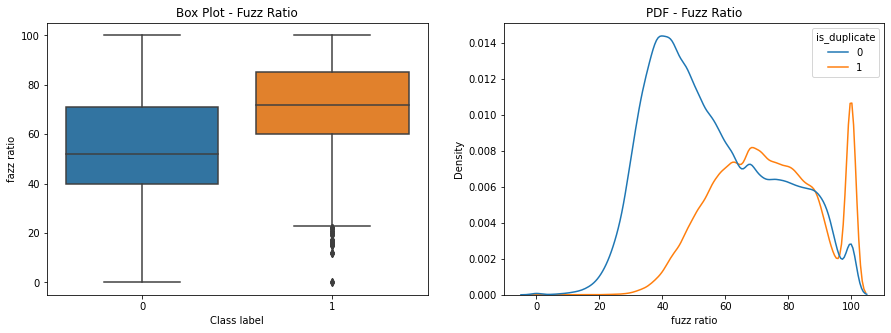

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_ratio' , data=df)
plt.title('Box Plot - Fuzz Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Ratio')
plt.xlabel('fuzz ratio')

plt.show()

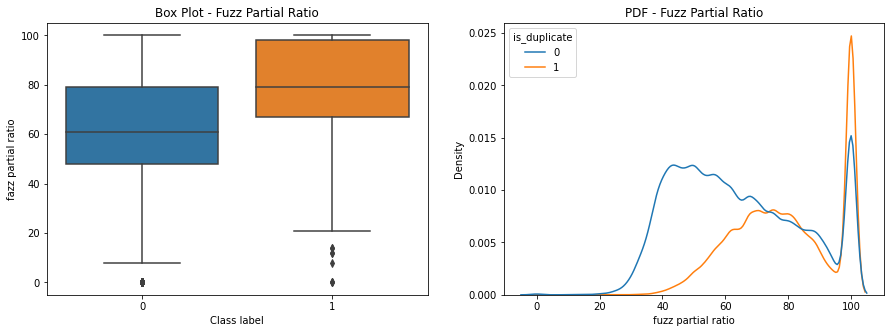

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_partial_ratio' , data=df)
plt.title('Box Plot - Fuzz Partial Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz partial ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_partial_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Partial Ratio')
plt.xlabel('fuzz partial ratio')

plt.show()

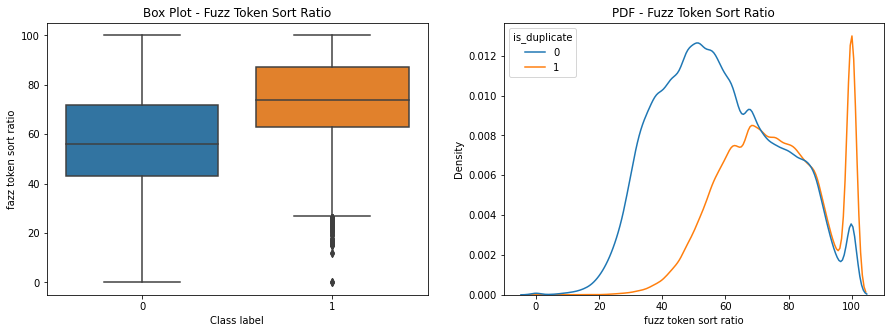

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_sort_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Sort Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token sort ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_sort_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Sort Ratio')
plt.xlabel('fuzz token sort ratio')

plt.show()

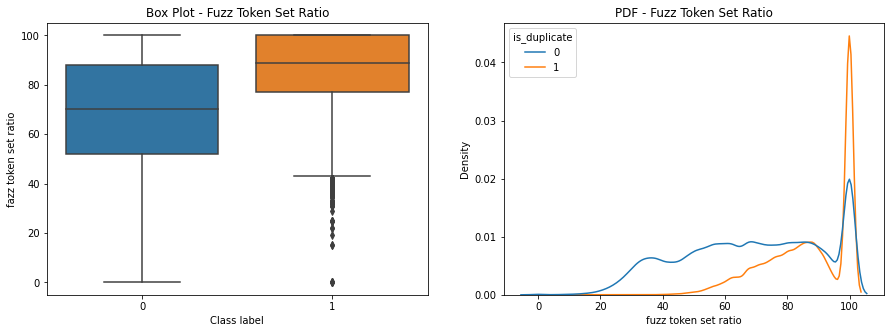

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_set_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Set Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token set ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_set_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Set Ratio')
plt.xlabel('fuzz token set ratio')

plt.show()

### Due to same distribution droping some features

In [43]:
#'ratio_of_common_words_of_q1q2_and_total_words' and 'ratio_of_common_words_of_q1q2_and_total_unique_words' 
# features are giving same distribution so droping 
# 'ratio_of_common_words_of_q1q2_and_total_unique_words' feature

df = df.drop('ratio_of_common_words_of_q1q2_and_total_unique_words' , axis=1)
df.shape


(404287, 23)

In [44]:
# 'fuzz_ratio' and 'fuzz_token_sort_ratio'
# features are giving same distribution so droping 'fuzz_ratio'

df = df.drop('fuzz_ratio' , axis=1)
df.shape

(404287, 22)

In [45]:
df['question1'] = df['question1'].apply(lambda text : str(text))
df['question2'] = df['question2'].apply(lambda text : str(text))

In [46]:
df.shape

(404287, 22)

### Showing Worlcloud

In [47]:
from wordcloud import WordCloud

In [48]:
duplicate = df[df['is_duplicate']==1]
non_duplicate = df[df['is_duplicate']==0]

duplicate = np.array([duplicate['question1'] , duplicate['question2']]).flatten()
non_duplicate = np.array([non_duplicate['question1'], non_duplicate['question2']]).flatten()

dup_str = ' '.join(duplicate)
non_dup_str = ' '.join(non_duplicate)

stop_words = set(stopwords.words('english'))



Word cloud for duplicate pairs


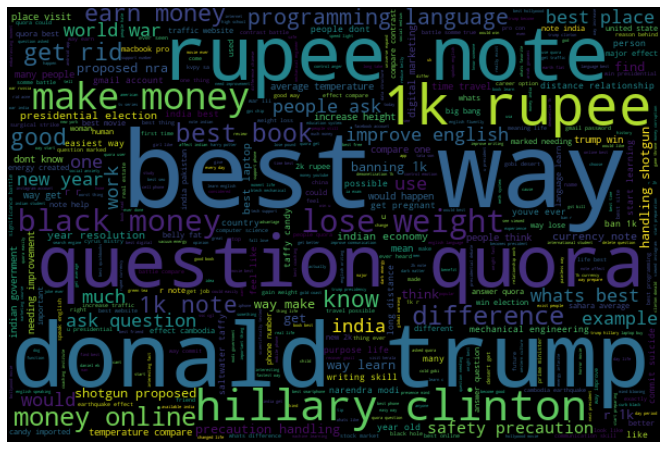

In [49]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Word cloud for non duplicate pairs


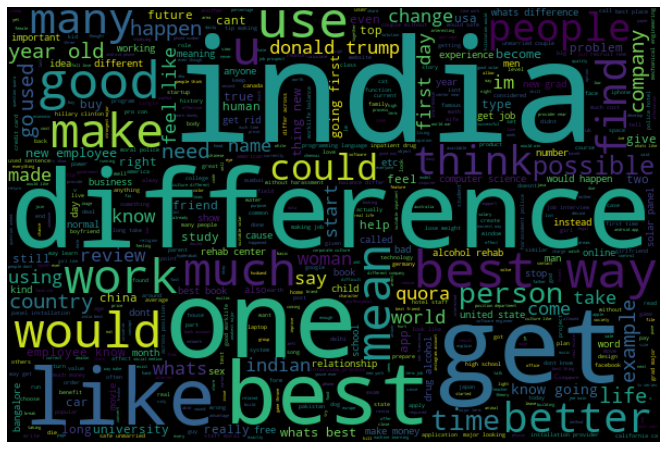

In [50]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(non_dup_str)

print('Word cloud for non duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

## Vectorization

In [51]:
from numpy import vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [52]:
nlp = spacy.load('en_core_web_sm')

In [53]:
# Merge texts
questions = list(data['question1'])+list(data['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

#  dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [54]:
vecs1 = []

# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(data['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # Word2Vec
        vec1 = word1.vector
        # Fetch df score
        try: idf = word2tfidf[str(word1)]
        except: idf = 0
        # Compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
data['q1_feats_m'] = list(vecs1)


100%|█████████████████████████████████████████████████████████████████████████| 404287/404287 [32:05<00:00, 209.91it/s]


In [55]:
data.shape

(404287, 7)

In [56]:
vecs2 = []
for qu2 in tqdm(list(data['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # Word2Vec
        vec2 = word2.vector
        # Fetch df score
        try: idf = word2tfidf[str(word2)]
        except: idf = 0
        # Compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
data['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404287/404287 [31:06<00:00, 216.63it/s]


In [57]:
data.shape

(404287, 8)

In [58]:
df1 = df.drop(['qid1' , 'qid2' , 'question1' , 'question2'] , axis=1)
df2 = data.drop(['qid1' , 'qid2' , 'question1' , 'question2' , 'is_duplicate'], axis=1)

In [59]:
print(df1.shape)
print(df2.shape)

(404287, 18)
(404287, 3)


In [60]:
df2_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist() , index = df2.index)
df2_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist() , index = df2.index)

In [61]:
print(df2_q1.shape)
print(df2_q2.shape)

(404287, 96)
(404287, 96)


In [62]:
df2_q1['id'] = df1['id']
df2_q2['id'] = df1['id']

In [63]:
df2 = df2_q1.merge(df2_q2 , on='id' , how='left')

In [64]:
df2.shape

(404287, 193)

In [65]:
result = df1.merge(df2 , on='id' , how='left')

In [66]:
result.shape

(404287, 210)

In [67]:
result.head()

,id,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,sum_of_total_words_of_q1_and_q2,number_of_unique_words_in_q1,number_of_unique_words_in_q2,sum_of_total_uinque_words_of_q1_and_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,41,35,7,6,13,6,5,11,...,23.793527,-20.588515,-25.390726,12.380482,-19.671285,16.618804,30.438969,43.384315,5.521890,2.243517
1,1,0,31,67,4,9,13,3,8,11,...,68.032480,1.352713,-25.395087,-7.580493,-23.430162,3.710800,1.435847,44.218931,11.410575,22.943352
2,2,0,44,36,6,5,11,6,5,11,...,-10.696344,-35.324732,-20.233555,40.031745,-22.515536,12.892494,0.084753,21.583730,24.523884,-7.576810
3,3,0,21,40,3,5,8,3,5,8,...,6.891576,-21.247961,0.394707,41.386888,-9.613209,18.265146,-1.723275,1.429064,18.121389,18.178995
4,4,0,60,29,10,5,15,10,5,15,...,17.671451,-11.538381,-11.433053,14.088320,-32.658980,6.244056,20.535041,17.647704,12.484855,-12.859798


In [68]:
result.isnull().sum().sum()

181

In [69]:
result = result.dropna()

In [ ]:
result.shape

## Data splitting

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [72]:
result = result.drop('id' , axis=1)

In [73]:
X = result.drop('is_duplicate' , axis=1)
Y = result['is_duplicate']

In [74]:
print(X.shape , Y.shape)

(404166, 208) (404166,)


In [75]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size=0.3 , random_state=1)

In [76]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(282916, 208) (121250, 208) (282916,) (121250,)


## Error Analysis

In [77]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:

class EvaluateModel:
    def __init__(self, x_test, y_test, model):
        self.x_test = x_test
        self.y_test = y_test
        self.model = model

    def evaluate_model(self):
        print("Evaluating the model:- ")
        y_pred = self.model.predict(self.x_test)
        print("Accuracy Score:- ", accuracy_score(self.y_test, y_pred))
        print("Precision Score:- ", precision_score(self.y_test, y_pred))
        print("Recall Score:- ", recall_score(self.y_test, y_pred))
        print("F1 Score:- ", f1_score(self.y_test, y_pred))
        print(
            "Log Loss:- ", log_loss(self.y_test, self.model.predict_proba(self.x_test))
        )
        print("Completed evaluating the model")

    def plot_confusion_matrix(self, test_y, predict_y):
        confusion = confusion_matrix(test_y, predict_y)

        Recall = ((confusion.T) / (confusion.sum(axis=1))).T
        # divide each element of the confusion matrix with the sum of elements in that column

        Precision = confusion / confusion.sum(axis=0)
        # divide each element of the confusion matrix with the sum of elements in that row

        plt.figure(figsize=(20, 4))

        labels = [0, 1]
        cmap = sns.light_palette("blue")
        plt.subplot(1, 3, 1)
        sns.heatmap(
            confusion,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Confusion matrix")

        plt.subplot(1, 3, 2)
        sns.heatmap(
            Precision,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Precision matrix")

        plt.subplot(1, 3, 3)
        sns.heatmap(
            Recall,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Recall matrix")

        plt.show()

    def plot_roc_curve(self, test_y, predict_y):
        auroc = roc_auc_score(test_y, predict_y)
        print("AUROC Score:- ", auroc)
        fpr, tpr, _ = roc_curve(test_y, predict_y)
        plt.plot(
            fpr, tpr, linestyle="--", label="Prediction_for_lr (AUROC = %0.3f)" % auroc
        )
        plt.title("ROC Plot")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

### XG Boost Model

In [79]:
def Xgboost_model(x_train , y_train , fine_tuning=True):
    if fine_tuning:
        print("Started Finetuning the model:- ")
        n_estimators = [50, 100, 150, 200]
        max_depth = [2, 4, 6, 8]
        learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        min_child_weight = [1, 2, 3, 4, 5]
        gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "min_child_weight": min_child_weight,
            "gamma": gamma,
        }
        xgb = XGBClassifier()
        clf = RandomizedSearchCV(xgb, params, cv=5, n_jobs=-1)
        clf.fit(x_train, y_train)
        print("Finished Hyperparameter search")
        return clf
    else:
        print("Started training the model:- ")
        xgb = XGBClassifier(
            learning_rate=0.3,
            max_delta_step=0,
            max_depth=8,
            min_child_weight=1,
            n_estimators=50,
            n_jobs=16,
            num_parallel_tree=1,
            random_state=0,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            subsample=1.0,
            tree_method="exact",
            validate_parameters=1,
            verbosity=None,
        )
        xgb.fit(x_train, y_train)
        print("Completed training the model")
        return xgb


In [80]:
xgb = Xgboost_model(x_train , y_train , fine_tuning=False)

Started training the model:- 


c:\users\gkirt\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed training the model


In [81]:
xgb_predict = xgb.predict(x_test)

In [82]:
evaluate_xgb = EvaluateModel(x_test , y_test , xgb)
evaluate_xgb.evaluate_model()

Evaluating the model:- 
Accuracy Score:-  0.7836206185567011
Precision Score:-  0.7068218672945776
Recall Score:-  0.7093430233854248
F1 Score:-  0.7080802011705276
Log Loss:-  0.4236552012126856
Completed evaluating the model


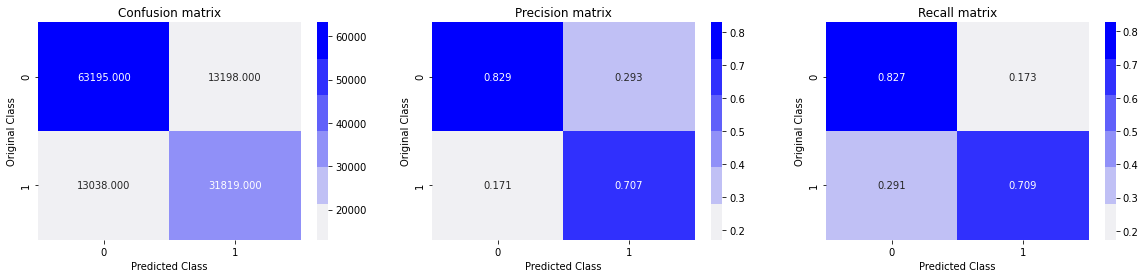

In [83]:
evaluate_xgb.plot_confusion_matrix(y_test , xgb_predict)

AUROC Score:-  0.7682892515379862


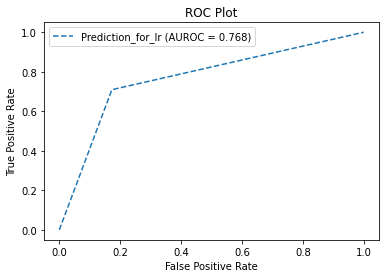

In [84]:
evaluate_xgb.plot_roc_curve(y_test , xgb_predict)

### SVM Model

In [85]:
# def svm_model(x_train , y_train , fine_tuning=True): 
#     if fine_tuning:  
#         print("Started Finetuning the model:- ")
#         C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#         gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#         params = {
#             "C": C,
#             "gamma": gamma,
#         }
#         svm = SVC()
#         clf = RandomizedSearchCV(svm, params, cv=5, n_jobs=-1)
#         clf.fit(x_train,y_train)
#         print("Finished Hyperparameter search")
#         return clf
#     else:
#         print("Started training the model:- ")
#         svm = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#             decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#             max_iter=-1, probability=False, random_state=None, shrinking=True,
#             tol=0.001, verbose=False)
#         svm.fit(x_train, y_train)
#         print("Completed training the model")
#         return svm 
# svm = svm_model(x_train , y_train , fine_tuning=False)
# svm_predict = svm.predict(x_test)
# evaluate_svm = EvaluateModel(x_test , y_test , svm)
# evaluate_svm.evaluate_model()
# evaluate_svm.plot_confusion_matrix(y_test , svm_predict)
# evaluate_svm.plot_roc_curve(y_test , svm_predict)

### Logistic Regression

In [ ]:
# def logistic_regression_model(x_train , y_train):
#     print("Training the model logistic regression model:- ")
#     log_reg = LogisticRegression(max_iter=1000)
#     log_reg.fit(x_train, y_train)

#     print("Completed training the model")
#     return log_reg
# lr = logistic_regression_model(x_train , y_train)
# lr_predict = lr.predict(x_test)
# evaluate_lr = EvaluateModel(x_test , y_test , lr)
# evaluate_lr.evaluate_model()
# evaluate_lr.plot_confusion_matrix(y_test , lr_predict)
# evaluate_lr.plot_roc_curve(y_test , lr_predict)